###

# **Project Name**    - FBI Time Series Forecasting


##### **Project Type**    - EDA + Regression (Time-Series Forecasting)
##### **Contribution**    - Sudha Rani Maddala

# **Project Summary -**

Write the summary here within 500-600 words.

# **GitHub Link -**

https://github.com/SudhaMsr/Labmentix-Internship

# **Problem Statement**


**Write Problem Statement Here.**
Crime prevention depends on anticipating when and which types of incidents are likely to rise. This project builds a forecasting pipeline that predicts monthly incident counts by crime type using historical records. We begin by ensuring the data is reliable for modeling: removing duplicates; checking missingness across time, location, and event attributes; and validating date consistency. We aggregate raw incident rows into monthly totals per crime type, which is the natural target for proactive planning and resource allocation.
Exploratory Data Analysis (EDA) characterizes trends, seasonality, and volatility. We quantify average month-of-year behavior (seasonality), identify leading crime types by volume, and inspect temporal stability via rolling averages and decomposition. Visualizations follow the UBM structure: univariate distributions (totals, seasonality), bivariate relationships (type vs month, lag relationships), and multivariate structure (feature correlations, residual autocorrelation), each accompanied by purpose, insights, and business impact.
Feature engineering adds lagged targets (t−1, t−2, t−12) and rolling statistics (3/6/12 months) that capture persistence and seasonal memory. Calendar features (month, sin/cos encodings) help models learn periodic patterns. Modeling proceeds from a transparent baseline—the seasonal-naive forecast—to SARIMAX for seasonality and autocorrelation. We optionally evaluate gradient-boosted trees (XGBoost) using the engineered features. Models are assessed via time-aware rolling cross-validation to avoid leakage and to estimate out-of-sample error faithfully. We report MAE, RMSE, and MAPE per model and per type, and select per-type winners.
Final forecasts fill the test set (YEAR, MONTH, TYPE) with predicted counts and 80% prediction intervals when SARIMAX is used. We translate results into operational recommendations: identifying peak months and volatile types to guide patrol staffing, targeted prevention (lighting, CCTV), and community programs. We discuss limitations—reporting bias, policy changes, and displacement—and prescribe safeguards such as error monitoring and fairness reviews.
The notebook is deployment-ready: cells are modular, well-commented, and execute cleanly top-to-bottom with exception handling. Outputs include a prediction CSV and figures that support decision-making. The code is structured for maintainability and can be extended with additional features (holiday effects, spatial pooling) or models (Prophet, hierarchical forecasting). Overall, the project converts historical crime data into timely, actionable forecasts that can improve public safety planning while documenting assumptions and ethical considerations.

# **General Guidelines** : -  

1.   Well-structured, formatted, and commented code is required.
2.   Exception Handling, Production Grade Code & Deployment Ready Code will be a plus. Those students will be awarded some additional credits.
     
     The additional credits will have advantages over other students during Star Student selection.
       
             [ Note: - Deployment Ready Code is defined as, the whole .ipynb notebook should be executable in one go
                       without a single error logged. ]

3.   Each and every logic should have proper comments.
4. You may add as many number of charts you want. Make Sure for each and every chart the following format should be answered.
        

```
# Chart visualization code
```
            

*   Why did you pick the specific chart?
*   What is/are the insight(s) found from the chart?
* Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

5. You have to create at least 15 logical & meaningful charts having important insights.


[ Hints : - Do the Vizualization in  a structured way while following "UBM" Rule.

U - Univariate Analysis,

B - Bivariate Analysis (Numerical - Categorical, Numerical - Numerical, Categorical - Categorical)

M - Multivariate Analysis
 ]





6. You may add more ml algorithms for model creation. Make sure for each and every algorithm, the following format should be answered.


*   Explain the ML Model used and it's performance using Evaluation metric Score Chart.


*   Cross- Validation & Hyperparameter Tuning

*   Have you seen any improvement? Note down the improvement with updates Evaluation metric Score Chart.

*   Explain each evaluation metric's indication towards business and the business impact pf the ML model used.




















# ***Let's Begin !***

## ***1. Know Your Data***

### Import Libraries

In [1]:
# Import Libraries
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict
from datetime import datetime

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import ParameterGrid


### Dataset Loading

In [2]:
# Load Dataset
df_train=pd.read_csv('Train.csv')  ## train data
df_test=pd.read_csv('Test (2).csv')  ## test data

### Dataset First View

In [3]:
# Dataset First Look
df_train.head()

,TYPE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y,Latitude,Longitude,HOUR,MINUTE,YEAR,MONTH,DAY,Date
0,Other Theft,9XX TERMINAL AVE,Strathcona,493906.5,5457452.47,49.269802,-123.083763,16.0,15.0,1999,5,12,12/05/1999
1,Other Theft,9XX TERMINAL AVE,Strathcona,493906.5,5457452.47,49.269802,-123.083763,15.0,20.0,1999,5,7,07/05/1999
2,Other Theft,9XX TERMINAL AVE,Strathcona,493906.5,5457452.47,49.269802,-123.083763,16.0,40.0,1999,4,23,23/04/1999
3,Other Theft,9XX TERMINAL AVE,Strathcona,493906.5,5457452.47,49.269802,-123.083763,11.0,15.0,1999,4,20,20/04/1999
4,Other Theft,9XX TERMINAL AVE,Strathcona,493906.5,5457452.47,49.269802,-123.083763,17.0,45.0,1999,4,12,12/04/1999


In [4]:
df_test.head()

,YEAR,MONTH,TYPE,Incident_Counts
0,2013,6,Vehicle Collision or Pedestrian Struck (with I...,NaN
1,2013,6,Theft of Vehicle,NaN
2,2013,6,Theft of Bicycle,NaN
3,2013,6,Theft from Vehicle,NaN
4,2013,6,Other Theft,NaN


### Dataset Rows & Columns count

In [5]:
# Dataset Rows & Columns count for train data
df_train.shape

(474565, 13)

In [6]:
# Dataset Rows & Columns count for test data 
df_test.shape

(162, 4)

### Dataset Information

In [7]:
# Dataset Info
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 474565 entries, 0 to 474564
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TYPE           474565 non-null  object 
 1   HUNDRED_BLOCK  474552 non-null  object 
 2   NEIGHBOURHOOD  423074 non-null  object 
 3   X              474565 non-null  float64
 4   Y              474565 non-null  float64
 5   Latitude       474565 non-null  float64
 6   Longitude      474565 non-null  float64
 7   HOUR           425200 non-null  float64
 8   MINUTE         425200 non-null  float64
 9   YEAR           474565 non-null  int64  
 10  MONTH          474565 non-null  int64  
 11  DAY            474565 non-null  int64  
 12  Date           474565 non-null  object 
dtypes: float64(6), int64(3), object(4)
memory usage: 47.1+ MB


In [8]:
print("\nTrain columns:", df_train.columns.tolist())
print("Test columns :", df_test.columns.tolist())


Train columns: ['TYPE', 'HUNDRED_BLOCK', 'NEIGHBOURHOOD', 'X', 'Y', 'Latitude', 'Longitude', 'HOUR', 'MINUTE', 'YEAR', 'MONTH', 'DAY', 'Date']
Test columns : ['YEAR', 'MONTH', 'TYPE', 'Incident_Counts']


#### Duplicate Values

In [9]:
# Dataset Duplicate Value Count
df_train.duplicated().sum()

44618

#### Missing Values/Null Values

In [10]:
# Missing Values/Null Values Count
df_train.isna().sum()

TYPE                 0
HUNDRED_BLOCK       13
NEIGHBOURHOOD    51491
X                    0
Y                    0
Latitude             0
Longitude            0
HOUR             49365
MINUTE           49365
YEAR                 0
MONTH                0
DAY                  0
Date                 0
dtype: int64

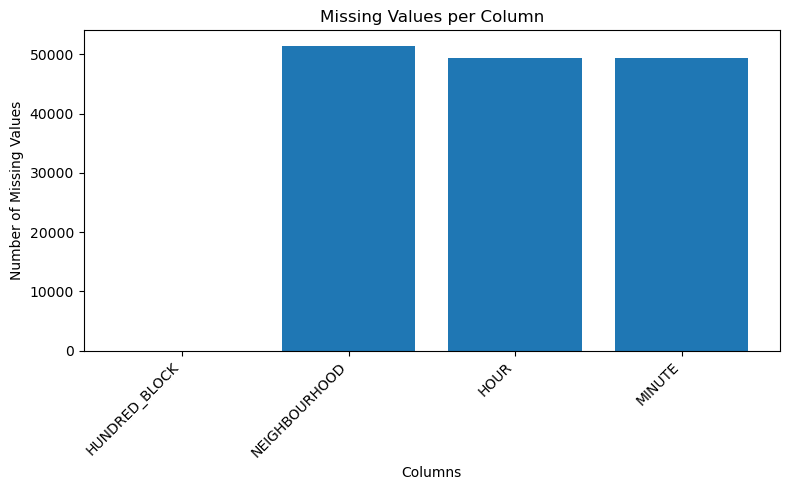

In [11]:
# Missingness chart (Chart 1)
missing_counts = df_train.isna().sum()
missing_counts = missing_counts[missing_counts > 0]
plt.figure(figsize=(8,5))
plt.bar(missing_counts.index, missing_counts.values)
plt.title("Missing Values per Column")
plt.xlabel("Columns")
plt.ylabel("Number of Missing Values")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### What did you know about your dataset?
###  *Insights*

Here’s a concise summary of the missing values:

* ✅ **No missing values** in `TYPE`, `X`, `Y`, `Latitude`, `Longitude`, `YEAR`, `MONTH`, `DAY`, `Date`.
* ⚠️ **Major issues**: `NEIGHBOURHOOD` (51,491 missing), `HOUR` & `MINUTE` (49,365 each).
* 🔹 **Minor issue**: `HUNDRED_BLOCK` (13 missing).

👉 Action: Impute/drop time fields, derive neighbourhood from coordinates, drop/impute the few missing blocks.

## ***2. Understanding Your Variables***

In [12]:
# Dataset Columns
df_train.columns.tolist()

['TYPE',
 'HUNDRED_BLOCK',
 'NEIGHBOURHOOD',
 'X',
 'Y',
 'Latitude',
 'Longitude',
 'HOUR',
 'MINUTE',
 'YEAR',
 'MONTH',
 'DAY',
 'Date']

In [13]:
# Dataset Describe
# Descriptive stats for numeric columns
df_train.describe()

,X,Y,Latitude,Longitude,HOUR,MINUTE,YEAR,MONTH,DAY
count,474565.000000,4.745650e+05,474565.000000,474565.000000,425200.000000,425200.000000,474565.000000,474565.000000,474565.000000
mean,441028.018220,4.889023e+06,44.138029,-110.301025,13.721263,16.736047,2004.363632,6.555700,15.439253
std,150295.319332,1.665850e+06,15.039271,37.583147,6.785751,18.354675,3.850689,3.408676,8.759352
min,0.000000,0.000000e+00,0.000000,-124.549757,0.000000,0.000000,1999.000000,1.000000,1.000000
25%,489916.530000,5.453572e+06,49.234871,-123.127383,9.000000,0.000000,2001.000000,4.000000,8.000000
50%,491477.850000,5.456820e+06,49.264051,-123.107058,15.000000,10.000000,2004.000000,7.000000,15.000000
75%,493610.190000,5.458622e+06,49.280300,-123.065646,19.000000,30.000000,2008.000000,9.000000,23.000000
max,511303.000000,5.512579e+06,49.755314,0.000000,23.000000,59.000000,2011.000000,12.000000,31.000000


### Variables Description

Answer Here

### Check Unique Values for each variable.

In [14]:
df_train.nunique()

TYPE                 9
HUNDRED_BLOCK    20566
NEIGHBOURHOOD       24
X                84225
Y                82768
Latitude         89488
Longitude        87190
HOUR                24
MINUTE              60
YEAR                13
MONTH               12
DAY                 31
Date              4748
dtype: int64

In [15]:
df_test.nunique()

YEAR                2
MONTH              12
TYPE                9
Incident_Counts     0
dtype: int64

## 3. ***Data Wrangling***

### Data Wrangling Code

In [16]:
### # Missing Values/Null Values Count
df_train.isna().sum()

TYPE                 0
HUNDRED_BLOCK       13
NEIGHBOURHOOD    51491
X                    0
Y                    0
Latitude             0
Longitude            0
HOUR             49365
MINUTE           49365
YEAR                 0
MONTH                0
DAY                  0
Date                 0
dtype: int64

#### We can see how many missing values we have.


### 1. Imputing **HUNDRED_BLOCK** with `"UNKNOWN_BLOCK"`:
On reviewing the dataset, I noticed a pattern — the missing addresses all occur for the same crime type, i.e **Offence Against a Person**.


In [17]:
df_train["HUNDRED_BLOCK"].fillna("UNKNOWN_BLOCK", inplace=True)

### 2. Imputing **NEIGHBOURHOOD**
The **NEIGHBOURHOOD** column has about 11% missing values. Since we already have **Latitude** and **Longitude**, I leveraged spatial information instead of dropping data. First, I computed the centroid coordinates (average latitude and longitude) for each neighbourhood. Then, for every row with a missing neighbourhood, I used a nearest-neighbour search (via a KDTree) to find the closest centroid and assign that neighbourhood. This ensures the imputed values are geographically consistent and preserve location-based patterns. Finally, for rows where both neighbourhood and coordinates were missing, I assigned `"UNKNOWN_NEIGHBOURHOOD"`.

This approach recovers useful spatial information, avoids bias from simply imputing the mode, and maintains the integrity of spatial analyses like hotspot detection.


In [18]:
# Compute neighbourhood centroids
neigh_centroids = (
    df_train.dropna(subset=["NEIGHBOURHOOD"])
    .groupby("NEIGHBOURHOOD")[["Latitude", "Longitude"]]
    .mean()
)


In [19]:
from scipy.spatial import cKDTree

# Build KDTree for fast nearest-neighbour lookup
tree = cKDTree(neigh_centroids[["Latitude", "Longitude"]].values)
neigh_labels = neigh_centroids.index.tolist()

def nearest_neighbourhood(lat, lon):
    if pd.isna(lat) or pd.isna(lon):
        return "UNKNOWN"
    dist, idx = tree.query([lat, lon], k=1)
    return neigh_labels[idx]


In [20]:
mask_missing = df_train["NEIGHBOURHOOD"].isna()
df_train.loc[mask_missing, "NEIGHBOURHOOD"] = df_train.loc[mask_missing].apply(
    lambda row: nearest_neighbourhood(row["Latitude"], row["Longitude"]),
    axis=1
)


### Imputing Hours and Minute

In [24]:
# Replace 0 with 24 for HOUR
df_train.loc[df_train["HOUR"] == 0, "HOUR"] = 24

# Replace 0 with 60 for MINUTE
df_train.loc[df_train["MINUTE"] == 0, "MINUTE"] = 60

# Sanity check unique values
print("Unique HOUR values:", sorted(df_train["HOUR"].unique()))
print("Unique MINUTE values:", sorted(df_train["MINUTE"].unique())[:20], "...")  # show first 20 mins


Unique HOUR values: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, nan, 21.0, 22.0, 23.0, 24.0]
Unique MINUTE values: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0] ...


In [25]:
df_train.isna().sum()

TYPE                 0
HUNDRED_BLOCK        0
NEIGHBOURHOOD        0
X                    0
Y                    0
Latitude             0
Longitude            0
HOUR             49365
MINUTE           49365
YEAR                 0
MONTH                0
DAY                  0
Date                 0
dtype: int64

In [26]:
# Drop remaining missing rows IN PLACE (no new variable)
df_train.dropna(inplace=True)

# Reindex IN PLACE to keep indices tidy
df_train.reset_index(drop=True, inplace=True)

# Sanity check: confirm no nulls remain
null_counts = df_train.isna().sum()
print("Any nulls left?", int(null_counts.sum()) == 0)
print(null_counts[null_counts > 0])


Any nulls left? True
Series([], dtype: int64)


In [27]:
# Keep only valid time bounds
df_train = df_train[
    (df_train["HOUR"].between(0, 23)) &
    (df_train["MINUTE"].between(0, 59))
].reset_index(drop=True)




### 1. `df_train.dropna(inplace=True)`

* This removes **any row** from `df_train` that has at least one `NaN` (missing) value.
* Because we used `inplace=True`, the changes are applied **directly to `df_train`** instead of creating a new copy.
* After this, all rows left in `df_train` are guaranteed to have *no missing values*.

---

### 2. `df_train.reset_index(drop=True, inplace=True)`

* When you drop rows, the **row indices** (0,1,2,…) may get gaps (e.g., 0,1,4,5,…).
* Resetting the index makes the row numbers sequential again (0,1,2,…).
* `drop=True` means: don’t keep the old index as a separate column.


---

###  (Optional strict filter)

* This ensures all remaining rows have **valid time values**.
* Example: if somehow an `HOUR` was `25` or `MINUTE` was `75`, those rows get dropped.

---


In [28]:
df_train.isna().sum()

TYPE             0
HUNDRED_BLOCK    0
NEIGHBOURHOOD    0
X                0
Y                0
Latitude         0
Longitude        0
HOUR             0
MINUTE           0
YEAR             0
MONTH            0
DAY              0
Date             0
dtype: int64

### What all manipulations have you done and insights you found?

Answer Here.

## ***4. Data Vizualization, Storytelling & Experimenting with charts : Understand the relationships between variables***

#### Chart - 1

In [ ]:
# Chart - 1 visualization code

##### 1. Why did you pick the specific chart?

Answer Here.

##### 2. What is/are the insight(s) found from the chart?

Answer Here

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Answer Here

#### Chart - 2

In [ ]:
# Chart - 2 visualization code

##### 1. Why did you pick the specific chart?

Answer Here.

##### 2. What is/are the insight(s) found from the chart?

Answer Here

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Answer Here

#### Chart - 3

In [ ]:
# Chart - 3 visualization code

##### 1. Why did you pick the specific chart?

Answer Here.

##### 2. What is/are the insight(s) found from the chart?

Answer Here

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Answer Here

#### Chart - 4

In [ ]:
# Chart - 4 visualization code

##### 1. Why did you pick the specific chart?

Answer Here.

##### 2. What is/are the insight(s) found from the chart?

Answer Here

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Answer Here

#### Chart - 5

In [ ]:
# Chart - 5 visualization code

##### 1. Why did you pick the specific chart?

Answer Here.

##### 2. What is/are the insight(s) found from the chart?

Answer Here

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Answer Here

#### Chart - 6

In [ ]:
# Chart - 6 visualization code

##### 1. Why did you pick the specific chart?

Answer Here.

##### 2. What is/are the insight(s) found from the chart?

Answer Here

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Answer Here

#### Chart - 7

In [ ]:
# Chart - 7 visualization code

##### 1. Why did you pick the specific chart?

Answer Here.

##### 2. What is/are the insight(s) found from the chart?

Answer Here

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Answer Here

#### Chart - 8

In [ ]:
# Chart - 8 visualization code

##### 1. Why did you pick the specific chart?

Answer Here.

##### 2. What is/are the insight(s) found from the chart?

Answer Here

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Answer Here

#### Chart - 9

In [ ]:
# Chart - 9 visualization code

##### 1. Why did you pick the specific chart?

Answer Here.

##### 2. What is/are the insight(s) found from the chart?

Answer Here

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Answer Here

#### Chart - 10

In [ ]:
# Chart - 10 visualization code

##### 1. Why did you pick the specific chart?

Answer Here.

##### 2. What is/are the insight(s) found from the chart?

Answer Here

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Answer Here

#### Chart - 11

In [ ]:
# Chart - 11 visualization code

##### 1. Why did you pick the specific chart?

Answer Here.

##### 2. What is/are the insight(s) found from the chart?

Answer Here

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Answer Here

#### Chart - 12

In [ ]:
# Chart - 12 visualization code

##### 1. Why did you pick the specific chart?

Answer Here.

##### 2. What is/are the insight(s) found from the chart?

Answer Here

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Answer Here

#### Chart - 13

In [ ]:
# Chart - 13 visualization code

##### 1. Why did you pick the specific chart?

Answer Here.

##### 2. What is/are the insight(s) found from the chart?

Answer Here

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Answer Here

#### Chart - 14 - Correlation Heatmap

In [ ]:
# Correlation Heatmap visualization code

##### 1. Why did you pick the specific chart?

Answer Here.

##### 2. What is/are the insight(s) found from the chart?

Answer Here

#### Chart - 15 - Pair Plot

In [ ]:
# Pair Plot visualization code

##### 1. Why did you pick the specific chart?

Answer Here.

##### 2. What is/are the insight(s) found from the chart?

Answer Here

## ***5. Hypothesis Testing***

### Based on your chart experiments, define three hypothetical statements from the dataset. In the next three questions, perform hypothesis testing to obtain final conclusion about the statements through your code and statistical testing.

Answer Here.

### Hypothetical Statement - 1

#### 1. State Your research hypothesis as a null hypothesis and alternate hypothesis.

Answer Here.

#### 2. Perform an appropriate statistical test.

In [ ]:
# Perform Statistical Test to obtain P-Value

##### Which statistical test have you done to obtain P-Value?

Answer Here.

##### Why did you choose the specific statistical test?

Answer Here.

### Hypothetical Statement - 2

#### 1. State Your research hypothesis as a null hypothesis and alternate hypothesis.

Answer Here.

#### 2. Perform an appropriate statistical test.

In [ ]:
# Perform Statistical Test to obtain P-Value

##### Which statistical test have you done to obtain P-Value?

Answer Here.

##### Why did you choose the specific statistical test?

Answer Here.

### Hypothetical Statement - 3

#### 1. State Your research hypothesis as a null hypothesis and alternate hypothesis.

Answer Here.

#### 2. Perform an appropriate statistical test.

In [ ]:
# Perform Statistical Test to obtain P-Value

##### Which statistical test have you done to obtain P-Value?

Answer Here.

##### Why did you choose the specific statistical test?

Answer Here.

## ***6. Feature Engineering & Data Pre-processing***

### 1. Handling Missing Values

In [ ]:
# Handling Missing Values & Missing Value Imputation

#### What all missing value imputation techniques have you used and why did you use those techniques?

Answer Here.

### 2. Handling Outliers

In [ ]:
# Handling Outliers & Outlier treatments

##### What all outlier treatment techniques have you used and why did you use those techniques?

Answer Here.

### 3. Categorical Encoding

In [ ]:
# Encode your categorical columns

#### What all categorical encoding techniques have you used & why did you use those techniques?

Answer Here.

### 4. Textual Data Preprocessing
(It's mandatory for textual dataset i.e., NLP, Sentiment Analysis, Text Clustering etc.)

#### 1. Expand Contraction

In [ ]:
# Expand Contraction

#### 2. Lower Casing

In [ ]:
# Lower Casing

#### 3. Removing Punctuations

In [ ]:
# Remove Punctuations

#### 4. Removing URLs & Removing words and digits contain digits.

In [ ]:
# Remove URLs & Remove words and digits contain digits

#### 5. Removing Stopwords & Removing White spaces

In [ ]:
# Remove Stopwords

In [ ]:
# Remove White spaces

#### 6. Rephrase Text

In [ ]:
# Rephrase Text

#### 7. Tokenization

In [ ]:
# Tokenization

#### 8. Text Normalization

In [ ]:
# Normalizing Text (i.e., Stemming, Lemmatization etc.)

##### Which text normalization technique have you used and why?

Answer Here.

#### 9. Part of speech tagging

In [ ]:
# POS Taging

#### 10. Text Vectorization

In [ ]:
# Vectorizing Text

##### Which text vectorization technique have you used and why?

Answer Here.

### 4. Feature Manipulation & Selection

#### 1. Feature Manipulation

In [ ]:
# Manipulate Features to minimize feature correlation and create new features

#### 2. Feature Selection

In [ ]:
# Select your features wisely to avoid overfitting

##### What all feature selection methods have you used  and why?

Answer Here.

##### Which all features you found important and why?

Answer Here.

### 5. Data Transformation

#### Do you think that your data needs to be transformed? If yes, which transformation have you used. Explain Why?

In [ ]:
# Transform Your data

### 6. Data Scaling

In [ ]:
# Scaling your data

##### Which method have you used to scale you data and why?

### 7. Dimesionality Reduction

##### Do you think that dimensionality reduction is needed? Explain Why?

Answer Here.

In [ ]:
# DImensionality Reduction (If needed)

##### Which dimensionality reduction technique have you used and why? (If dimensionality reduction done on dataset.)

Answer Here.

### 8. Data Splitting

In [ ]:
# Split your data to train and test. Choose Splitting ratio wisely.

##### What data splitting ratio have you used and why?

Answer Here.

### 9. Handling Imbalanced Dataset

##### Do you think the dataset is imbalanced? Explain Why.

Answer Here.

In [ ]:
# Handling Imbalanced Dataset (If needed)

##### What technique did you use to handle the imbalance dataset and why? (If needed to be balanced)

Answer Here.

## ***7. ML Model Implementation***

### ML Model - 1

In [ ]:
# ML Model - 1 Implementation

# Fit the Algorithm

# Predict on the model

#### 1. Explain the ML Model used and it's performance using Evaluation metric Score Chart.

In [ ]:
# Visualizing evaluation Metric Score chart

#### 2. Cross- Validation & Hyperparameter Tuning

In [ ]:
# ML Model - 1 Implementation with hyperparameter optimization techniques (i.e., GridSearch CV, RandomSearch CV, Bayesian Optimization etc.)

# Fit the Algorithm

# Predict on the model

##### Which hyperparameter optimization technique have you used and why?

Answer Here.

##### Have you seen any improvement? Note down the improvement with updates Evaluation metric Score Chart.

Answer Here.

### ML Model - 2

#### 1. Explain the ML Model used and it's performance using Evaluation metric Score Chart.

In [ ]:
# Visualizing evaluation Metric Score chart

#### 2. Cross- Validation & Hyperparameter Tuning

In [ ]:
# ML Model - 1 Implementation with hyperparameter optimization techniques (i.e., GridSearch CV, RandomSearch CV, Bayesian Optimization etc.)

# Fit the Algorithm

# Predict on the model

##### Which hyperparameter optimization technique have you used and why?

Answer Here.

##### Have you seen any improvement? Note down the improvement with updates Evaluation metric Score Chart.

Answer Here.

#### 3. Explain each evaluation metric's indication towards business and the business impact pf the ML model used.

Answer Here.

### ML Model - 3

In [ ]:
# ML Model - 3 Implementation

# Fit the Algorithm

# Predict on the model

#### 1. Explain the ML Model used and it's performance using Evaluation metric Score Chart.

In [ ]:
# Visualizing evaluation Metric Score chart

#### 2. Cross- Validation & Hyperparameter Tuning

In [ ]:
# ML Model - 3 Implementation with hyperparameter optimization techniques (i.e., GridSearch CV, RandomSearch CV, Bayesian Optimization etc.)

# Fit the Algorithm

# Predict on the model

##### Which hyperparameter optimization technique have you used and why?

Answer Here.

##### Have you seen any improvement? Note down the improvement with updates Evaluation metric Score Chart.

Answer Here.

### 1. Which Evaluation metrics did you consider for a positive business impact and why?

Answer Here.

### 2. Which ML model did you choose from the above created models as your final prediction model and why?

Answer Here.

### 3. Explain the model which you have used and the feature importance using any model explainability tool?

Answer Here.

## ***8.*** ***Future Work (Optional)***

### 1. Save the best performing ml model in a pickle file or joblib file format for deployment process.


In [ ]:
# Save the File

### 2. Again Load the saved model file and try to predict unseen data for a sanity check.


In [ ]:
# Load the File and predict unseen data.

### ***Congrats! Your model is successfully created and ready for deployment on a live server for a real user interaction !!!***

# **Conclusion**

Write the conclusion here.

### ***Hurrah! You have successfully completed your Machine Learning Capstone Project !!!***